# Variational Autoencoder (VAE) for MNIST Generation
### Implementation using TensorFlow 2.x and Keras

**Project Overview:**
This notebook demonstrates a Variational Autoencoder (VAE) trained on the MNIST dataset. Unlike a standard Autoencoder that maps inputs to a single point in latent space, a VAE maps inputs to a *distribution*. This allows us to sample from the latent space to generate entirely new, realistic handwritten digits.

**Key Components:**
1. **Encoder:** Compresses the input into two parameters: `z_mean` and `z_log_var`.
2. **Reparameterization Trick:** Samples a point `z` from the distribution while allowing gradients to flow back.
3. **Decoder:** Reconstructs the image from the sampled point `z`.
4. **Loss Function:** Combines Reconstruction Loss (making the image look like the original) and KL Divergence (making the latent space follow a standard normal distribution).

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set seed for reproducibility to ensure the noise and initialization are consistent
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


## 1. Defining the Core VAE Components

### Sampling Layer
This layer implements the reparameterization trick: `z = mu + epsilon * sigma`, where `epsilon` is sampled from $N(0, 1)$.

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    
    This implementation follows the 'Reparameterization Trick' which allows 
    backpropagation through a stochastic node by shifting the randomness 
    to an external source (epsilon).
    """
    def call(self, inputs):
        # The encoder provides the mean (mu) and log variance (log_var) for the latent distribution
        z_mean, z_log_var = inputs
        # Get the batch size and dimensions dynamically
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        # Sample epsilon from a standard normal distribution (mean=0, std=1)
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        # Reparameterize: z = mean + std * epsilon
        # std = exp(0.5 * log_var)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Encoder and Decoder Architecture
We use a multi-layer perceptron (Dense layers) for both the encoder and decoder.

In [3]:
def build_encoder(input_dim=784, h_dim1=512, h_dim2=256, z_dim=20):
    """Builds the encoder network which maps input images to a distribution in latent space."""
    # Define the input shape (784 features for a flattened 28x28 image)
    encoder_inputs = keras.Input(shape=(input_dim,), name="encoder_input")
    
    # Internal hidden layers for feature extraction
    x = layers.Dense(h_dim1, activation="relu", name="encoder_dense_1")(encoder_inputs)
    x = layers.Dense(h_dim2, activation="relu", name="encoder_dense_2")(x)
    
    # The encoder predicts two parameters for each latent dimension:
    # 1. z_mean: The average value around which the data is centered
    z_mean = layers.Dense(z_dim, name="z_mean")(x)
    # 2. z_log_var: The log variance which controls the spread of the distribution
    z_log_var = layers.Dense(z_dim, name="z_log_var")(x)
    
    # Sample the latent vector z using our custom sampling layer
    z = Sampling(name="sampling_layer")([z_mean, z_log_var])
    
    # The encoder model outputs the mean, log_var, and the sampled z
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

def build_decoder(z_dim=20, h_dim1=512, h_dim2=256, output_dim=784):
    """Builds the decoder network which maps latent vectors back to the original image space."""
    # Define the input shape as the latent vector size
    latent_inputs = keras.Input(shape=(z_dim,), name="latent_input")
    
    # Symmetrical hidden layers (expanding back to 784 pixels)
    x = layers.Dense(h_dim2, activation="relu", name="decoder_dense_1")(latent_inputs)
    x = layers.Dense(h_dim1, activation="relu", name="decoder_dense_2")(x)
    
    # Final layer uses sigmoid activation to output pixel values between 0 and 1
    decoder_outputs = layers.Dense(output_dim, activation="sigmoid", name="decoder_output")(x)
    
    # The decoder model takes z and outputs the reconstructed image
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder

# Instantiate networks to visualize summaries of parameters
encoder_model = build_encoder()
decoder_model = build_decoder()

encoder_model.summary()
decoder_model.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense_1     │ (None, 512)       │    401,920 │ encoder_input[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense_2     │ (None, 256)       │    131,328 │ encoder_dense_1[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 20)        │      5,140 │ encoder_dense_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 20)        │      5,140 │ encoder_dense_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_layer      │ (None, 20)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 543,528 (2.07 MB)

 Trainable params: 543,528 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ latent_input (InputLayer)       │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_1 (Dense)         │ (None, 256)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_2 (Dense)         │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 784)            │       402,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 539,152 (2.06 MB)

 Trainable params: 539,152 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

### VAE Model Class
Handling the custom training loop by overriding `train_step` to calculate total loss (Reconstruction + KL).

In [4]:
class VAE(keras.Model):
    """Integration of Encoder and Decoder into a trainable VAE model."""
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        # Track metrics for average loss values throughout the epoch
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        # List of metrics to be monitored during fit()
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        """Custom training step for the VAE model."""
        # MNIST data loader returns (images, labels); VAE is unsupervised, labels are ignored
        if isinstance(data, tuple):
            data = data[0]
        
        with tf.GradientTape() as tape:
            # 1. Forward Pass through the Encoder
            z_mean, z_log_var, z = self.encoder(data)
            
            # 2. Forward Pass through the Decoder (Reconstruction)
            reconstruction = self.decoder(z)
            
            # 3. Calculate Reconstruction Loss
            # Measures how similar the generated image is to the original pixels
            # Using Binary Cross Entropy and summing over all pixels (axis -1)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=-1
                )
            )
            
            # 4. Calculate KL Divergence Loss (The Regularizer)
            # Encourages the latent space to follow a standard normal distribution N(0, 1)
            # Formula: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            # The final objective to minimize
            total_loss = reconstruction_loss + kl_loss
            
        # 5. Backward Pass: Compute gradients with respect to weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        
        # 6. Weight Update: Use Adam to update parameters
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # 7. Update Trackers for Metric Logging
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        # Return a dictionary of results to be shown in the training progress bar
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## 2. Preparing the MNIST Data
We load the dataset, normalize it, and flatten it into vectors of size 784.

In [5]:
# Load MNIST training and test data from Keras internal dataset repository
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

# Normalize pixel values from [0, 255] to [0.0, 1.0] for stable neural network training
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = mnist_digits.astype("float32") / 255.0

# Flatten images: Convert (28x28) pixel grids into (784,) intensity vectors
mnist_digits = np.reshape(mnist_digits, (-1, 784))

print(f"Total training images processed: {mnist_digits.shape[0]}")
print(f"Flattened image dimension: {mnist_digits.shape[1]}")

Total training images processed: 70000
Flattened image dimension: 784


## 3. Training the Model
We instantiate the components and train for 10 epochs using a batch size of 128.

In [6]:
# Initialize the encoder and decoder components with a 20-dimensional latent space
encoder = build_encoder(z_dim=20)
decoder = build_decoder(z_dim=20)

# Assemble and compile the VAE model
vae_model = VAE(encoder, decoder)
vae_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

# Fit the model: The VAE will learn the structure of handwritten digits
history = vae_model.fit(
    mnist_digits, 
    epochs=10, 
    batch_size=128, 
    verbose=1
)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - kl_loss: 1.6342 - loss: 32.8731 - reconstruction_loss: 31.2389
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - kl_loss: 4.1358 - loss: 28.6948 - reconstruction_loss: 24.5590
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - kl_loss: 4.8452 - loss: 27.7178 - reconstruction_loss: 22.8726
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - kl_loss: 5.1814 - loss: 27.3445 - reconstruction_loss: 22.1631
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - kl_loss: 5.4115 - loss: 27.0914 - reconstruction_loss: 21.6799
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - kl_loss: 5.5839 - loss: 26.9260 - reconstruction_loss: 21.3421
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 5.7006 - loss: 26.7818 - reconstruction_loss: 21.0812
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - kl_loss: 5.7989 - loss: 26.6776 - reconstruction_loss: 20.8786
Epoch 9/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - kl_loss: 5

### Loss Visualization
Visualizing how the reconstruction and regularization losses changed over time.

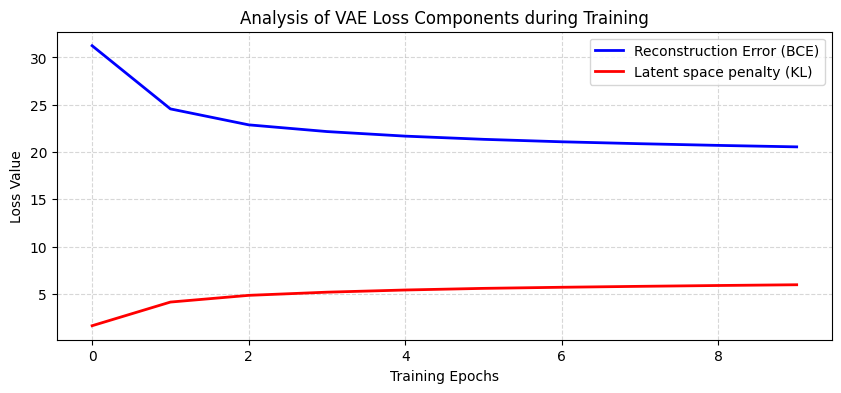

In [7]:
# Plot the loss trends to verify convergence
plt.figure(figsize=(10, 4))
plt.plot(history.history['reconstruction_loss'], label='Reconstruction Error (BCE)', color='blue', linewidth=2)
plt.plot(history.history['kl_loss'], label='Latent space penalty (KL)', color='red', linewidth=2)
plt.xlabel('Training Epochs')
plt.ylabel('Loss Value')
plt.title('Analysis of VAE Loss Components during Training')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## 4. Generative Power: Creating New Digits
By sampling random points from the latent space (Gaussian noise), we produce brand new handwritten digits.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


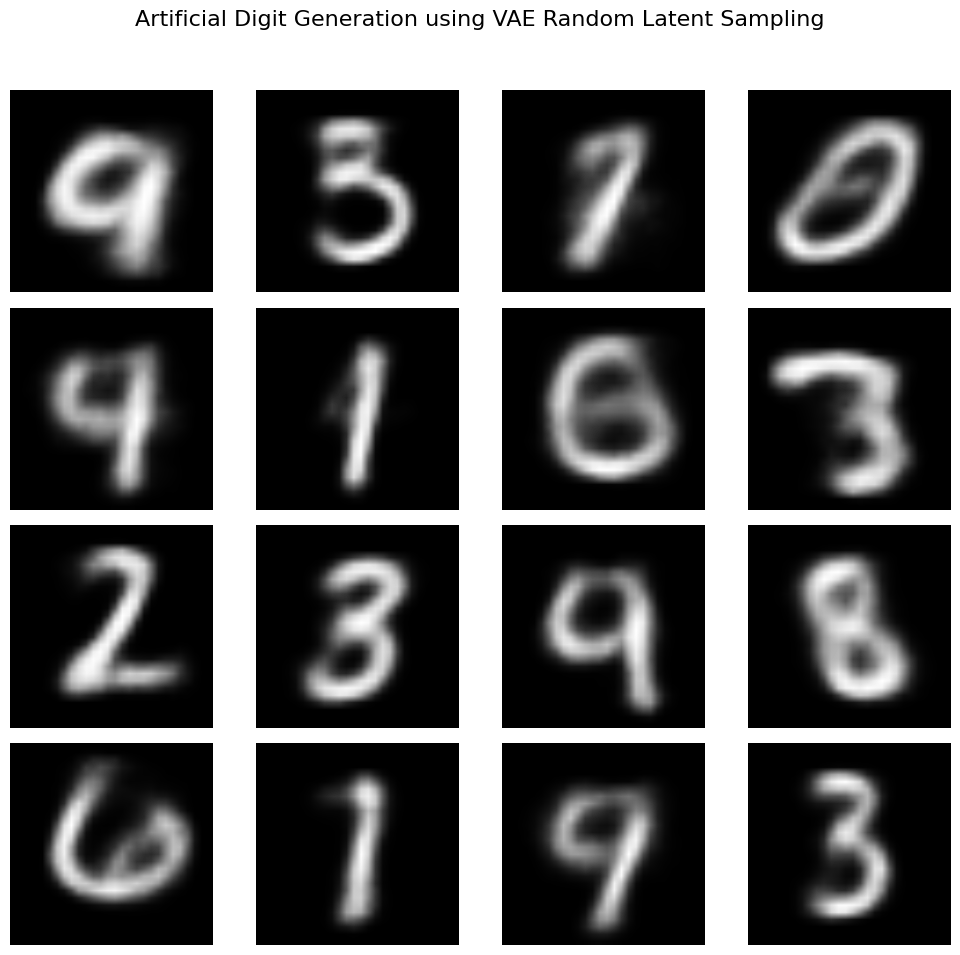

In [8]:
# Define the number of new digits to generate
num_samples = 16
# Step 1: Create 16 random coordinate vectors in the 20D latent space
z_noise = np.random.normal(size=(num_samples, 20))

# Step 2: Use the decoder to interpret these random points as digit images
generated_samples = decoder.predict(z_noise)

# Step 3: Reshape the flattened results back to 28x28 for visualization
generated_samples = generated_samples.reshape(-1, 28, 28)

# Step 4: Display the newly generated digits
plt.figure(figsize=(10, 10))
for i in range(num_samples):
    plt.subplot(4, 4, i + 1)
    # Interpolation 'bilinear' makes the generated samples look smoother
    plt.imshow(generated_samples[i], cmap="gray", interpolation="bilinear")
    plt.axis("off")
plt.suptitle("Artificial Digit Generation using VAE Random Latent Sampling", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 5. Reconstruction Capability: Real vs. Generated
Passing real MNIST digits through the VAE to see how well the bottleneck representation captures essential features.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


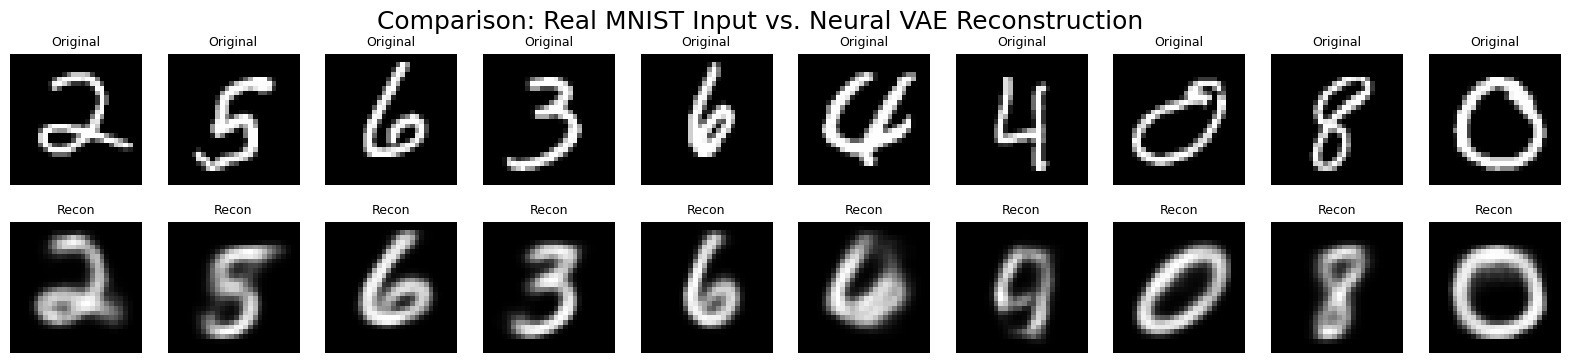

In [9]:
# Pick 10 random real image indices from the dataset
rand_indices = np.random.choice(len(mnist_digits), 10)
original_imgs = mnist_digits[rand_indices]

# Step 1: Encode images to get their latent mean values (representation)
_, _, z_vals = encoder.predict(original_imgs)

# Step 2: Use the Decoder to reconstruct those images from the latent representations
recon_imgs = decoder.predict(z_vals)

# Step 3: Reshape for display (Flattened vector -> Image grid)
original_imgs = original_imgs.reshape(-1, 28, 28)
recon_imgs = recon_imgs.reshape(-1, 28, 28)

# Step 4: Plotting Comparison - Original vs. Synthetic Reconstruction
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    # Top Row: Real Images from MNIST
    axes[0, i].imshow(original_imgs[i], cmap="gray")
    axes[0, i].set_title("Original", fontsize=9)
    axes[0, i].axis("off")
    
    # Bottom Row: Reconstructions generated by the VAE
    axes[1, i].imshow(recon_imgs[i], cmap="gray")
    axes[1, i].set_title("Recon", fontsize=9)
    axes[1, i].axis("off")

plt.suptitle("Comparison: Real MNIST Input vs. Neural VAE Reconstruction", fontsize=18)
plt.show()